# General fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Definition of model

Consider controlled parameter range is [-1,1]

In [2]:
# True functional dependece for data generation (triangle wave)

def mytrue(x):
    
    tri = x + (x>0.5)*(1-2*x) + (x<-0.5)*(-1-2*x)

    return tri

In [3]:
# Fit model - Fourier series
# Sum of terms:  1, sin(ax), cos(ax), sin(2ax), cos(2ax) ...

# Basic function (return function value only)

def myfun(x,par):

    # Scaling factor
    
    a = par[0]

    # output array
    
    val = np.zeros(x.size)

    # Constant term
    
    val = par[1]

    for ip in range(2,par.size,2):   # Size of par need to be even !
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

    return val

In [4]:
# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,par.size))

    # Scaling factor (global)
    
    a = par[0]

    # Constant term (global)
    
    val = par[1]

    der[:,1] = 1
    
    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

        der[:,ip] = np.sin(pw*a*x)
        der[:,ip+1] = np.cos(pw*a*x)
        
        der[:,0] += par[ip]*pw*x*np.cos(pw*a*x)
        der[:,0] -= par[ip+1]*pw*x*np.sin(pw*a*x)
        
    return val,der

### (2) Generate pseudo data to fit

In [5]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,20)

# Measurement precision - assume slow variation with x

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (3) Initialize an iterative fit

In [22]:
# Number of function parameters to consider  (must be even!!!)

Nfun = 8

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 3.
parini[2] = 0.5

# Initial function vales

fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [3.  0.  0.5 0.  0.  0.  0.  0. ]
  chi^2 =   291.730   chi^2/N = 14.58652 


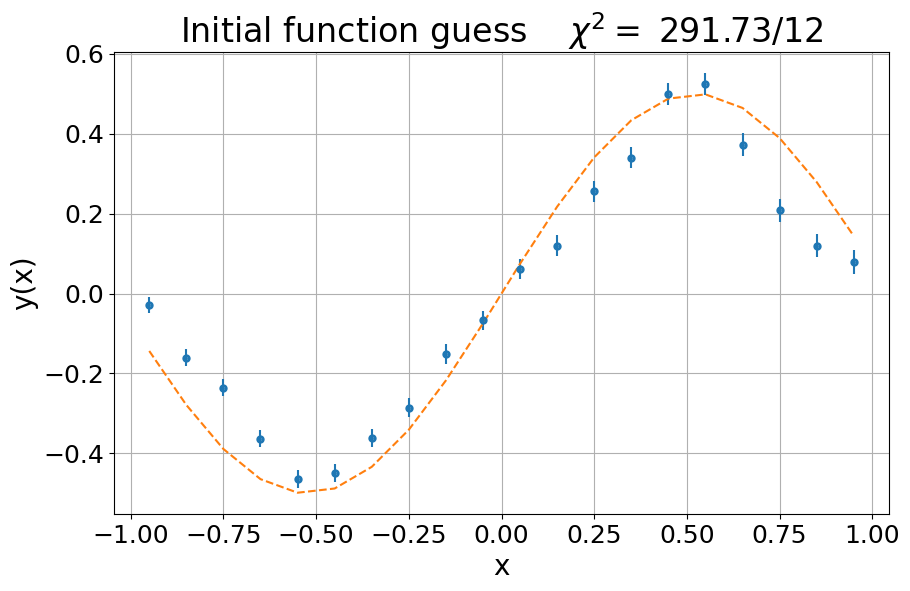

In [23]:
plt.figure(figsize=(10, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fini,'--')

plt.title('Initial function guess    $\\chi^2 =$ {:.2f}/{}'.format(chi2ini,xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit1_ini.png'
plt.savefig(fname)

### (4) Iterative fit procedure

In [24]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.00001     # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini

Nit = 0

# work space
    
A = np.zeros((Nfun,Nfun))
B = np.zeros(Nfun)
Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A  +  lam * np.identity(Nfun)
    
    # Inverse of the matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Estimate the distance to minimum from current step (in units of current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  chi^2 =  {:8.3f}   chi^2/N = {:8.5f} ".format(chi2new,chi2new/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if chi2new < chi2min :  # Iteration successful, fit got closer to the minimum
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:                   # Iteration failed, reduce step
        lam *= 10



Iteration step  1  with lambda =  0.01
  [ 2.976e+00  9.165e-04  4.033e-01 -6.037e-03  4.162e-02 -8.937e-03
 -7.009e-02 -4.291e-03]
  chi^2 =    19.743   chi^2/N =  1.64523 
  distance to minimum:  154.07229705445152

Iteration step  2  with lambda =  0.001
  [ 3.069e+00  8.091e-04  4.125e-01 -6.159e-03  2.048e-02 -9.179e-03
 -6.340e-02 -4.083e-03]
  chi^2 =    19.714   chi^2/N =  1.64280 
  distance to minimum:  0.5419639493793932

Iteration step  3  with lambda =  0.0001
  [ 2.949e+00  8.195e-04  4.009e-01 -5.548e-03  4.777e-02 -9.368e-03
 -7.188e-02 -3.073e-03]
  chi^2 =    19.896   chi^2/N =  1.65801 
  distance to minimum:  0.6418317641537034

Iteration step  4  with lambda =  0.001
  [ 2.949e+00  8.195e-04  4.009e-01 -5.548e-03  4.776e-02 -9.368e-03
 -7.188e-02 -3.072e-03]
  chi^2 =    19.896   chi^2/N =  1.65800 
  distance to minimum:  0.6417286052817801

Iteration step  5  with lambda =  0.01
  [ 2.949e+00  8.194e-04  4.009e-01 -5.548e-03  4.774e-02 -9.368e-03
 -7.188e-02 -3.

In [25]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix

Corr = Cov/np.outer(epar,epar)

np.set_printoptions(precision=3)

print("\n Correlation matrix\n")

for ip in range(par.size):
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))



 Fit results:

     par         sigma_p

     3.033  +/-  0.355 
     0.001  +/-  0.006 
     0.408  +/-  0.035 
    -0.006  +/-  0.008 
     0.029  +/-  0.080 
    -0.010  +/-  0.008 
    -0.065  +/-  0.025 
    -0.003  +/-  0.008 

 Correlation matrix

[ 1.     0.024  0.975 -0.233 -0.995 -0.015  0.949  0.167]
[ 0.024  1.     0.067 -0.065 -0.034  0.05   0.048 -0.038]
[ 0.975  0.067  1.    -0.243 -0.97  -0.033  0.925  0.169]
[-0.233 -0.065 -0.243  1.     0.25  -0.069 -0.259  0.018]
[-0.995 -0.034 -0.97   0.25   1.     0.01  -0.945 -0.175]
[-0.015  0.05  -0.033 -0.069  0.01   1.     0.044 -0.064]
[ 0.949  0.048  0.925 -0.259 -0.945  0.044  1.     0.144]
[ 0.167 -0.038  0.169  0.018 -0.175 -0.064  0.144  1.   ]

 chi^2 =    19.608   chi^2/Ndf =  1.63400 


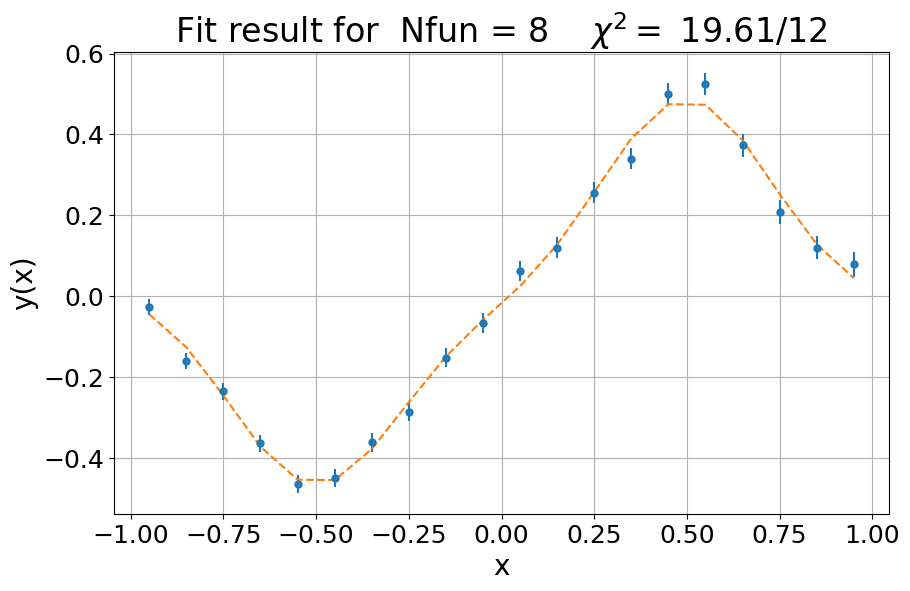

In [26]:
plt.figure(figsize=(10, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fvec,'--')

plt.title('Fit result for  Nfun = {}    $\\chi^2 =$ {:.2f}/{}'.format(Nfun,chi2,xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit1_'+str(Nfun)+'.png'
plt.savefig(fname)

### (5) Corresponding SciPy fit example

In [27]:
from scipy.optimize import curve_fit

From SciPy documentation:<br>
The model function ... must take the independent variable as the first argument and the parameters to fit as separate remaining arguments. <br>
$\Rightarrow$ need to define functions for specific Nfun

In [ ]:
def myfun4(x,p0,p1,p2,p3):
    val = p1 + p2*np.sin(p0*x) + p3*np.cos(p0*x)
    return val

def myfun6(x,p0,p1,p2,p3,p4,p5):
    val = myfun4(x,p0,p1,p2,p3) + p4*np.sin(2*p0*x) + p5*np.cos(2*p0*x)
    return val

def myfun8(x,p0,p1,p2,p3,p4,p5,p6,p7):
    val = myfun6(x,p0,p1,p2,p3,p4,p5) + p6*np.sin(3*p0*x) + p7*np.cos(3*p0*x)
    return val

def myfun10(x,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9):
    val = myfun4(x,p0,p1,p2,p3,p4,p5,p6,p7) + p8*np.sin(4*p0*x) + p9*np.cos(4*p0*x)
    return val

def myfun12(x,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11):
    val = myfun4(x,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9) + p10*np.sin(5*p0*x) + p11*np.cos(5*p0*x)
    return val

For correct function fit and uncertainty estimate:
  * specify input data uncertainties (<i> sigma = svec </i>)
  * switch off $\chi^2$ scaling (<i>absolute_sigma=True</i>)
  * set initial parameter values (<i>p0 = parini </i>)

In [29]:

if Nfun == 4:
    parcf, Covcf = curve_fit(myfun4, xvec, yvec, p0=parini, sigma=svec, absolute_sigma=True)
if Nfun == 6:
    parcf, Covcf = curve_fit(myfun6, xvec, yvec, p0=parini, sigma=svec, absolute_sigma=True)
if Nfun == 8:
    parcf, Covcf = curve_fit(myfun8, xvec, yvec, p0=parini, sigma=svec, absolute_sigma=True)
if Nfun == 10:
    parcf, Covcf = curve_fit(myfun10, xvec, yvec, p0=parini, sigma=svec, absolute_sigma=True)
if Nfun == 12:
    parcf, Covcf = curve_fit(myfun12, xvec, yvec, p0=parini, sigma=svec, absolute_sigma=True)
    
eparcf = np.sqrt(np.diagonal(Covcf))

print("\n curve_fit results:\n\n     par         sigma_p\n")

for ip in range(parcf.size):
    print("  %8.3f  +/- %6.3f " % (parcf[ip],eparcf[ip]))

# Calculate correlation matrix

Corrcf = Cov/np.outer(eparcf,eparcf)

np.set_printoptions(precision=3)

print("\n Correlation matrix\n")

for ip in range(parcf.size):
    print(Corrcf[ip,:])

# Fitted function

fveccf = myfun(xvec,parcf) 

# Chi^2 printout

chi2cf = np.sum((yvec-fveccf)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2cf,chi2cf/(xvec.size-Nfun)))



 curve_fit results:

     par         sigma_p

     3.033  +/-  0.355 
     0.001  +/-  0.006 
     0.409  +/-  0.035 
    -0.006  +/-  0.008 
     0.029  +/-  0.080 
    -0.010  +/-  0.008 
    -0.065  +/-  0.025 
    -0.003  +/-  0.008 

 Correlation matrix

[ 1.     0.024  0.974 -0.233 -0.995 -0.015  0.95   0.167]
[ 0.024  1.     0.067 -0.065 -0.034  0.05   0.048 -0.038]
[ 0.974  0.067  1.    -0.243 -0.97  -0.033  0.925  0.169]
[-0.233 -0.065 -0.243  0.999  0.25  -0.069 -0.259  0.018]
[-0.995 -0.034 -0.97   0.25   1.     0.01  -0.945 -0.176]
[-0.015  0.05  -0.033 -0.069  0.01   1.     0.044 -0.064]
[ 0.95   0.048  0.925 -0.259 -0.945  0.044  1.001  0.145]
[ 0.167 -0.038  0.169  0.018 -0.176 -0.064  0.145  1.   ]

 chi^2 =    19.608   chi^2/Ndf =  1.63400 
